In [1]:
%matplotlib notebook

import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import choice

import brainbox.behavior.wheel as wh
from brainbox.behavior.behavior import load_wheel_reaction_times
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves, extract_first_movement_times
from oneibl.one import ONE
one = ONE()

Connected to https://alyx.internationalbrainlab.org as miles
Connected to https://alyx.internationalbrainlab.org as miles


In [2]:
def eid2ref(eid):
    """
    Get human-readable session ref from path
    :param eid: The experiment uuid to find reference for
    :return: dict containing 'subject', 'date' and 'sequence'
    """
    path_str = str(one.path_from_eid(eid))
    pattern = r'(?P<subject>[\w-]+)([\\/])(?P<date>\d{4}-\d{2}-\d{2})(\2)(?P<sequence>\d{3})'
    match = re.search(pattern, path_str)
    return match.groupdict()

In [3]:
eid = 'eafbdb1a-8776-4390-b210-76b7509e31d0'
eid2ref(eid)

{'subject': 'CSHL055', 'date': '2020-02-10', 'sequence': '001'}

### Device 

The standard resolution of the rotary encoder is 1024 'ticks' per revolulation.  With quadrature (X4) encoding we measure four fronts giving from the device: low -> high and high -> low, from channels A and B.  Therefore the number of measured 'ticks' per revolution becomes 4096.

![Quadrature encoding schematic](http://www.ni.com/cms/images/devzone/tut/ipuuzhqc3503.jpg)

For more information on the rotary encoder see these links:  
[National Instruments guide to rotary encoders](http://www.ni.com/tutorial/7109/en/)  
[Datasheet for the Kübler](https://www.kuebler.com/pdf?2400-2420_en.pdf)

### Units
The wheel module contains some default values that are useful for determining the units of the raw data, and for interconverting your ALF position units.  

In [21]:
device_info = ('The wheel diameter is {} cm and the number of ticks is {} per revolution'
               .format(wh.WHEEL_DIAMETER, wh.ENC_RES))
print(device_info)

The wheel diameter is 6.2 cm and the number of ticks is 4096 per revolution


### Loading the wheel data
The wheel traces can be accessed via ONE.  There are two ALF files: `wheel.position` and `wheel.timestamps`.  The timestamps are, as usual, in seconds (same as the trials object) and the positions are in radians.  The positions are not evenly sampled, meaning that when the wheel doesn't move, no position is registered.  

More information on the ALF dataset types can be found [here](https://docs.google.com/document/d/1OqIqqakPakHXRAwceYLwFY9gOrm8_P62XIfCTnHwstg/edit#heading=h.hnjqyfnroyya).  

**NB**: There are some old `wheel.velocity` ALF files that contain the volocity measured as the diff between neighbouring samples.  Later on we describe a better way to calculate the velocity.

In [4]:
wheel = one.load_object(eid, 'wheel')

print('wheel.position: \n', wheel.position)
print('wheel.timestamps: \n', wheel.timestamps)

wheel.position: 
 [-3.86563159e-01 -3.92699082e-01 -3.98835005e-01 ... -5.65799610e+02
 -5.65805746e+02 -5.65811882e+02]
wheel.timestamps: 
 [6.79604098e-01 6.86161141e-01 6.92652183e-01 ... 3.73136665e+03
 3.73138577e+03 3.73141459e+03]


### Loading movement data
The wheel movement onsets and offsets can be calculated using the `wheel.movements` function.  The output of this function will soon be extracted as the 'wheelMoves' ALF (see below).  The movements algorithm requires the positions and timestamps to be evenly sampled so they should be interpolated first, which can be done with the `wheel.interpolate_position` function.  The default sampling frequency is 1000Hz.

<IPython.core.display.Javascript object>


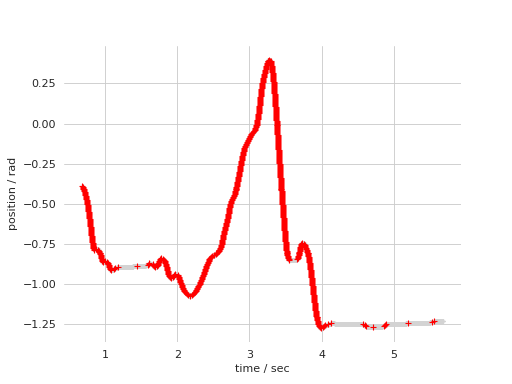

In [5]:
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 5  # Number of seconds to plot

# Plot the interpolated data points
mask = t < (t[0] + sec)
with sns.axes_style('whitegrid'):
    plt.plot(t[mask], pos[mask], 'k+', markeredgecolor='lightgrey', markersize=4)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
with sns.axes_style('whitegrid'):
    plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)

Once interpolated, the movements can be extracted from the position trace.  **NB**: The position thresholds are dependant on the wheel position units.  The defaults values are for the raw input of a X4 1024 encoder, so we will convert them to radians:

In [9]:
# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)

<IPython.core.display.Javascript object>


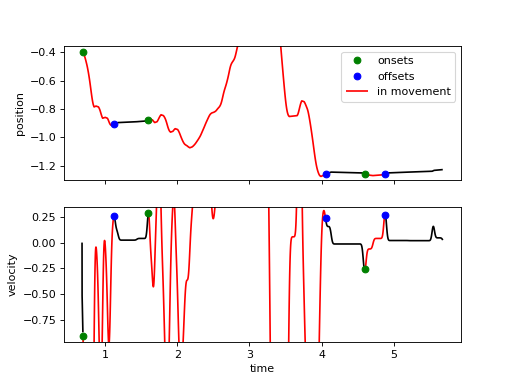

In [10]:
# Detect wheel movements for the first 5 seconds
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)

Although currently not extracted, there will soon be an ALF dataset type called 'wheelMoves'.  These will have two attributes:  
1. `wheelMoves.intervals` - An N-by-2 arrays where N is the number of movements detected.  The first column contains the movement onset time in absolute seconds; the second contains the offset.
2. `wheelMoves.peakAmplitude` - The absolute maximum amplitude of each detected wheel movement, relative to onset position.  This can be used to determine whether the movement was particularly large and therefore whether it was a flinch vs a determined movement.

The peak velocity times will not be saved into an ALF file.

You can extract the wheel moves with a single function.  Below we attempt to load the wheelMoves ALF and upon failing, extract it ourselves. 

In [11]:
try:
    # Warning: This object is currently not extracted (as of 2020-06-01)
    wheel_moves = one.load_object(eid, 'wheelMoves')
    assert wheel_moves, 'object not found'
except AssertionError:
    raw_dict = {'re_ts': wheel.timestamps, 're_pos': wheel.position}  # Rename keys for the extractor
    wheel_moves = extract_wheel_moves(raw_dict)

2020-05-26 16:01:58.64 WARNING  [one.py:259] eafbdb1a-8776-4390-b210-76b7509e31d0 does not contain any wheelMoves object datasets
2020-05-26 16:01:58.72 INFO     [ephys_fpga.py:356] Wheel in rad units using 4X encoding


### Calculating velocity
Wheel velocity can be calculated using the `velocity_smoothed` function, which returns the velocity and acceleration convolved with a Gaussian window.  As with the `movements` function, the input is expected to be evenly sampled, therefore you should interpolate the wheel data before calling this function.  The default window size of 3ms is reasonable, and interpolating at a frequency of 1000 (the default) is sufficiently high. 

In [6]:
# pos was the output of interpolate_position using the default frequency of 1000Hz
Fs = 1000
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position, freq=Fs)
vel, acc = wh.velocity_smoothed(pos, Fs)

### Last move onset
The `movements` algorithm is the recommended way of detecting movement onsets because it is quicker and more accurate, however there is another function that will return the last movement onset before a particular event.  This is useful for quickly finding the movement that reached threshold for a given trial.  This function finds the first sample after the velocity has been zero for at least 50ms.  Because it uses velocity, the smoothed derivative of position, it is less accurate.  **NB**: The more accurate approach is to find all moves for which the onset occured before feedback time and the offset occured afterwards.

<IPython.core.display.Javascript object>


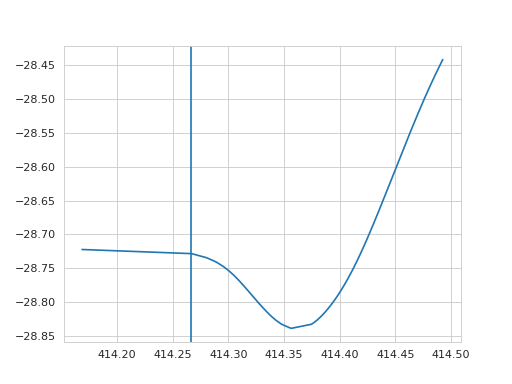

In [8]:
trial_data = one.load_object(eid, 'trials')
idx = 23 # trial index
ts = wh.last_movement_onset(t, vel, trial_data['feedback_times'][idx]);

mask = np.logical_and(trial_data['goCue_times'][idx] < t, t < trial_data['feedback_times'][idx])
with sns.axes_style('whitegrid'):
    plt.plot(t[mask], pos[mask]);
    plt.axvline(x=ts);

### Calculating reaction times
Reaction times based on wheel movements can be calculated with the `load_wheel_reaction_times` function which is located in the behavior module of brainbox.  

Reaction times are defined as the time between the go cue (onset tone) and the onset of the first substantial wheel movement.  A movement is considered sufficiently large if its peak amplitude is at least 1/3rd of the distance to threshold (~0.1 radians).

Negative times mean the onset of the movement occurred before the go cue.  Nans may occur if there was no detected movement withing the period, or when the goCue_times or feedback_times are nan.

The function loads the trials object and if firstMovement_times is not present it loads the wheel moves and extracts these times.

In [54]:
# Load the reaction times
rt = load_wheel_reaction_times(eid)

2020-05-26 21:39:17.135 WARNING  [one.py:259] eafbdb1a-8776-4390-b210-76b7509e31d0 does not contain any wheelMoves object datasets
2020-05-26 21:39:19.88 INFO     [ephys_fpga.py:357] Wheel in rad units using 4X encoding


<IPython.core.display.Javascript object>


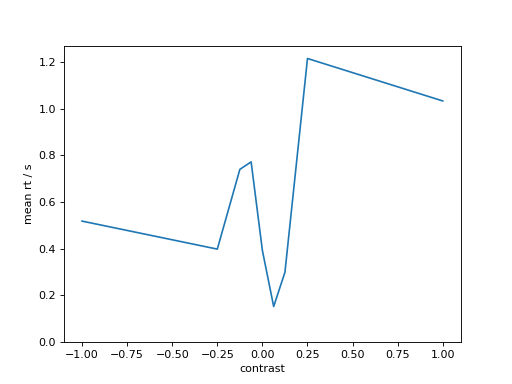

In [61]:
trial_data = one.load_object(eid, 'trials')

# Replace nans with zeros
trial_data.contrastRight[np.isnan(trial_data.contrastRight)] = 0
trial_data.contrastLeft[np.isnan(trial_data.contrastLeft)] = 0

contrast = trial_data.contrastRight - trial_data.contrastLeft
mean_rt = [np.nanmean(rt[contrast == c]) for c in set(contrast)]

# RT may be nan if there were no detected movements, or if the goCue or stimOn times were nan
xdata = np.unique(contrast)
plt.plot(xdata, mean_rt)

plt.xlabel('contrast')
plt.ylabel('mean rt / s')
plt.ylim(bottom=0);

## DataJoint Schema
There is also a share DJ table that has been populated using the same functions as above.

In [69]:
import datajoint as dj
from ibl_pipeline import acquisition, behavior
from uuid import UUID

dj_wheel = dj.create_virtual_module('wheel_moves', 'group_shared_wheel')

### WheelMoveSet
This table contains some movement information at the session level.

In [64]:
dj_wheel.WheelMoveSet.describe();

# Wheel movements occurring within a session
-> `ibl_acquisition`.`session`
---
n_movements          : int                          # total number of movements within the session
total_displacement   : float                        # total displacement of the wheel during session in radians
total_distance       : float                        # total movement of the wheel in radians



### WheelMoveSet.Move
This table contains each detected movement for a session.

In [67]:
dj_wheel.WheelMoveSet.Move.describe();

-> dj_wheel.WheelMoveSet
move_id              : int                          # movement id
---
movement_onset       : float                        # time of movement onset in seconds from session start
movement_offset      : float                        # time of movement offset in seconds from session start
max_velocity         : float                        # time of movement's peak velocity
movement_amplitude   : float                        # the absolute peak amplitude relative to onset position



### MovementTimes
This table contains movement information at the level of the trial.  Trials may not have an associated movement if the goCue or stimOn times were missing, or if no movements were detected for that trial.  `movement_onset` is the only field that is in absolute seconds.  

In [65]:
dj_wheel.MovementTimes.describe();

# Trial movements table
-> `ibl_behavior`.`_trial_set__trial`
---
-> dj_wheel.WheelMoveSet.Move
reaction_time        : float                        # time in seconds from go cue to first sufficiently large movement onset of the trial
final_movement       : tinyint                      # indicates whether movement onset was the one that reached threshold
movement_time        : float                        # time in seconds from first movement onset to feedback time
response_time        : float                        # time in seconds from go cue to feedback time
movement_onset       : float                        # time in seconds when first movement onset occurred



In [72]:
# Load the trials and trial movements for the same session we looked at above
session = acquisition.Session & {'session_uuid': UUID(eid)}
(dj_wheel.MovementTimes * behavior.TrialSet.Trial) & session

subject_uuid,session_start_time start time,trial_id trial identification number,move_id movement id,reaction_time time in seconds from go cue to first sufficiently large movement onset of the trial,final_movement indicates whether movement onset was the one that reached threshold,movement_time time in seconds from first movement onset to feedback time,response_time time in seconds from go cue to feedback time,movement_onset time in seconds when first movement onset occurred,trial_start_time beginning of quiescent period time (seconds),trial_end_time end of iti (seconds),trial_response_time,trial_response_choice which choice was made in choiceworld,trial_stim_on_time Time of stimulus in choiceworld (seconds),trial_stim_contrast_left contrast of the stimulus on the left,trial_stim_contrast_right contrast of the stimulus on the right,trial_go_cue_time,trial_go_cue_trigger_time,trial_feedback_time,"trial_feedback_type whether feedback is positive or negative in choiceworld (-1 for negative, +1 for positive)","trial_rep_num the repetition number of the trial, i.e. how many trials have been repeated on this side (counting from 1)",trial_stim_prob_left probability of the stimulus being present on left,trial_reward_volume,trial_iti_duration,trial_included whether the trial should be included
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,2,139,0.1922,1,0.554,0.7462,318.745,316.8516,320.868602,319.299,CW,318.55280000000005,0.125,0.0,318.554,318.553,319.29900000000004,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,3,140,6.5047,0,5.9845,12.4892,328.274,321.2422,335.818502,334.258,CW,321.76930000000004,0.0,0.0,321.77,321.769,334.2585,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,4,143,0.0698,1,0.2411,0.3109,336.839,336.1835,338.652502,337.08,CCW,336.76919999999996,0.0,0.0625,336.77,336.769,337.08009999999996,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,5,146,0.0535,1,0.2019,0.2554,339.855,339.0159,341.618802,340.057,CCW,339.8015,0.0,0.0625,339.802,339.802,340.0569,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,6,148,0.0334,1,0.3049,0.3383,343.035,341.9859,344.902002,343.34,CW,343.0016,0.25,0.0,343.003,343.002,343.3399,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,7,149,0.046,1,0.178,0.224,346.064,345.3023,347.801402,346.242,CCW,346.01800000000003,0.0,0.25,346.019,346.018,346.242,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,8,150,0.048,1,0.2071,0.2551,348.7,348.1644,350.468702,348.907,CCW,348.652,0.0,0.0,348.653,348.652,348.9071,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,9,151,0.0225,1,0.1705,0.193,352.074,350.8114,353.817802,352.244,CCW,352.0515,0.0,1.0,352.052,352.052,352.2445,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,10,156,-0.0769,1,0.3456,0.2687,368.008,367.4547,369.917602,368.353,CW,368.0849,0.0,0.0,368.086,368.085,368.35360000000003,1,None,0.5,1.5,nan,None
3614ee37-c892-4eb4-ab83-f6c1f3804977,2020-02-10 09:50:44,11,157,0.1793,1,0.0862,0.2655,370.964,370.2891,373.618002,371.049,CCW,370.78470000000004,0.0625,0.0,370.786,370.785,371.0502,-1,None,0.5,0.0,nan,None
